In [9]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 
from scipy.special import softmax 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys
sys.path.append('..')
from utils.fit import fit_bms
from utils.viz import viz 
viz.get_style()


## Parameter recovery

In [33]:
fname = f'../fits/param_recover-median-MOS6/fit_sub_info-MOS6-map.pkl'
with open(fname, 'rb')as handle: fit_info = pickle.load(handle)
params = [fit_info[k]['param'] for k in fit_info.keys()]
params = np.vstack(params)
params = pd.DataFrame(params, columns=fit_info[1]['param_name'])
params['α'] = params['α'].apply(lambda x:1/(1+np.exp(-x)))
params['α_act'] = params['α_act'].apply(lambda x: 1/(1+np.exp(-x)))
params.columns = [c+'_recover' for c in params.columns]
params_truth = pd.read_csv(f'../data/param_recover-truth-exp1data-MOS6.csv', index_col=0)
params_truth = params_truth.drop(columns=['sub_id'])
params_truth['α'] = params_truth['α'].apply(lambda x:1/(1+np.exp(-x)))
params_truth['α_act'] = params_truth['α_act'].apply(lambda x:1/(1+np.exp(-x)))
params_truth.columns = [c+'_truth' for c in params_truth.columns]
comb_data = pd.concat([params_truth, params], axis=1)
comb_data['group'] = 1

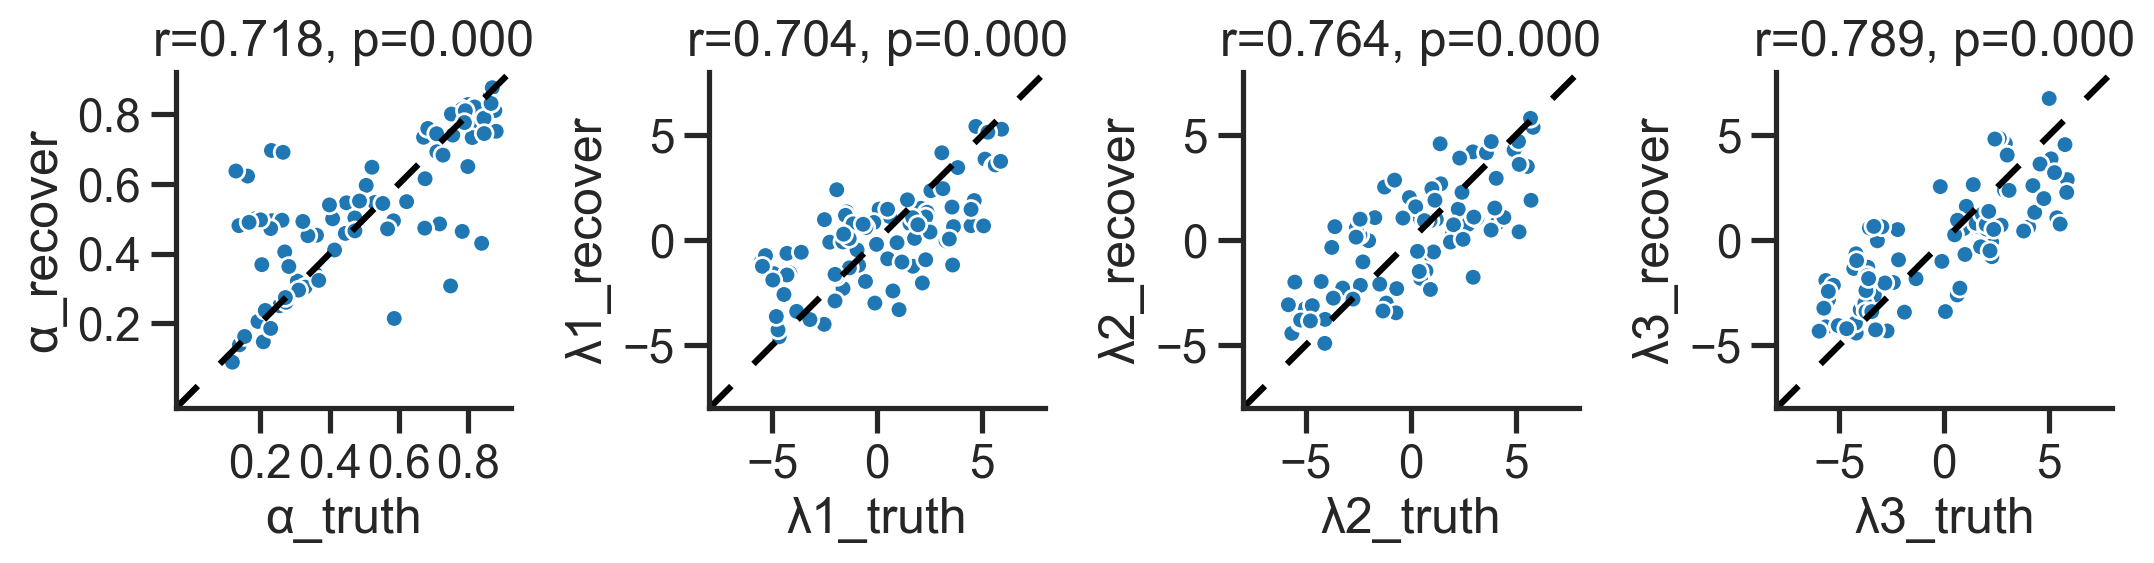

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(11, 3.5))
p_names = ['α', 'λ1', 'λ2', 'λ3']
for i, p in enumerate(p_names):
    ax = axs[i]
    sns.scatterplot(x=f'{p}_truth', y=f'{p}_recover',
                    hue='group', lw=1,
                    legend=False, size=40,
                    data=comb_data, ax=ax)
    ax.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    ax.set_box_aspect(1)
    cor = pg.corr(comb_data[f'{p}_truth'], comb_data[f'{p}_recover'])
    ax.set_title(f"r={cor['r'].values[0]:.3f}, p={cor['p-val'].values[0]:.3f}")

    if i in [1, 2, 3]: 
        ax.set_xlim([-8, 8]) 
        ax.set_ylim([-8, 8]) 
    else: 
        ax.set_xticks([.2, .4, .6, .8])
        ax.set_yticks([.2, .4, .6, .8])
fig.tight_layout()
plt.savefig('../figures/Fig7A_param_recovery.pdf', dpi=300)

## Model recovery

In [30]:
def get_recovery_matrix(tars, models, method):
    ## get BMS
    crs_all = []
    subj_lst = ['n33', 'n24', 'cb1', 'cb45', 'cb79', 'cb17', 'cb80', 'cb63', 'cb7',
                'n31', 'n19', 'n8', 'cb17', 'n33', 'n36', 'cb45', 'cb68', 'n19',
                'cb7', 'cb79', 'cb13', 'cb46', 'cb49', 'cb20', 'cb84', 'cb74', 'cb14', 'cb200',
                'cb75', 'cb13', 'cb20', 'cb46', 'cb105', 'cb108', 'cb13', 'cb30',
                'cb74', 'cb49', 'cb96', 'cb14']
    for tar in tars:
        data_set = f'exp1data-{tar}'
        fit_sub_info = []
        for i, m in enumerate(models):
            with open(f'../fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
                fit_info = pickle.load(handle)
            # get log post
            log_post = [fit_info[idx]['log_post'] for idx in subj_lst]
            bic      = [fit_info[idx]['bic'] for idx in subj_lst]
            h        = [fit_info[idx]['H'] for idx in subj_lst]
            n_param  = fit_info[list(subj_lst)[0]]['n_param']
            fit_sub_info.append({
                'log_post': log_post, 
                'bic': bic, 
                'n_param': n_param, 
                'H': h,
            })
        bms_results = fit_bms(fit_sub_info, use_bic=False)

            ## get nll, aic ,bic 
        cols = ['NLL', 'AIC', 'BIC', 'model', 'sub_id']
        crs = {k: [] for k in cols}
        for m in models:
            with open(f'../fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
                fit_info = pickle.load(handle) 
            # get log post
            nll = [-fit_info[idx]['log_like'] for idx in subj_lst]
            aic = [fit_info[idx]['aic'] for idx in subj_lst]
            bic = [fit_info[idx]['bic'] for idx in subj_lst]
            bic = [fit_info[idx]['bic'] for idx in subj_lst]
            crs['NLL'] += nll
            crs['AIC'] += aic
            crs['BIC'] += bic
            crs['model'] += [m]*len(nll)
            crs['sub_id'] += list(subj_lst)
        #crs['PXP'] = bms_results['pxp']
        crs = pd.DataFrame.from_dict(crs)
        for c in ['NLL', 'BIC', 'AIC']:
            tar_crs = len(models)*list(crs.query(f'model=="{tar}"')[c].values)
            crs[c] -= tar_crs
        crs_mean = crs.groupby(by='model')[
            ['NLL', 'AIC', 'BIC']].mean().reset_index()
        crs_mean = crs_mean.set_index('model').loc[models, :].reset_index()
        crs_mean['PXP'] = bms_results['pxp']
        crs_mean['tar'] = tar
        crs_all.append(crs_mean)
    crs_all = pd.concat(crs_all, axis=0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for i, c in enumerate(['AIC', 'BIC', 'PXP']):
        ax = axs[i]
        cr = crs_all.pivot_table(
            index='tar',
            columns='model',
            values=c,
        )
        m = cr.loc[models, models]
        sns.heatmap(m,
                    cmap='Greys_r' if i<2 else 'Greys', 
                    linewidths=.1,
                    vmax=50 if i<2 else 1,
                    cbar_kws={"shrink": 0.85},
                    ax=ax)
        ax.axhline(y=0, color='k',lw=5)
        ax.axhline(y=m.shape[0], color='k',lw=5)
        ax.axvline(x=0, color='k',lw=5)
        ax.axvline(x=m.shape[1], color='k',lw=5)
        ax.set_box_aspect(1)
        ax.set_title(r'$\Delta$'+c) if i<2 else ax.set_title(c) 
        ax.set_ylabel('Data-generating model') if i==0 else ax.set_ylabel('')
        ax.set_xlabel('Fitted model')
    fig.tight_layout()

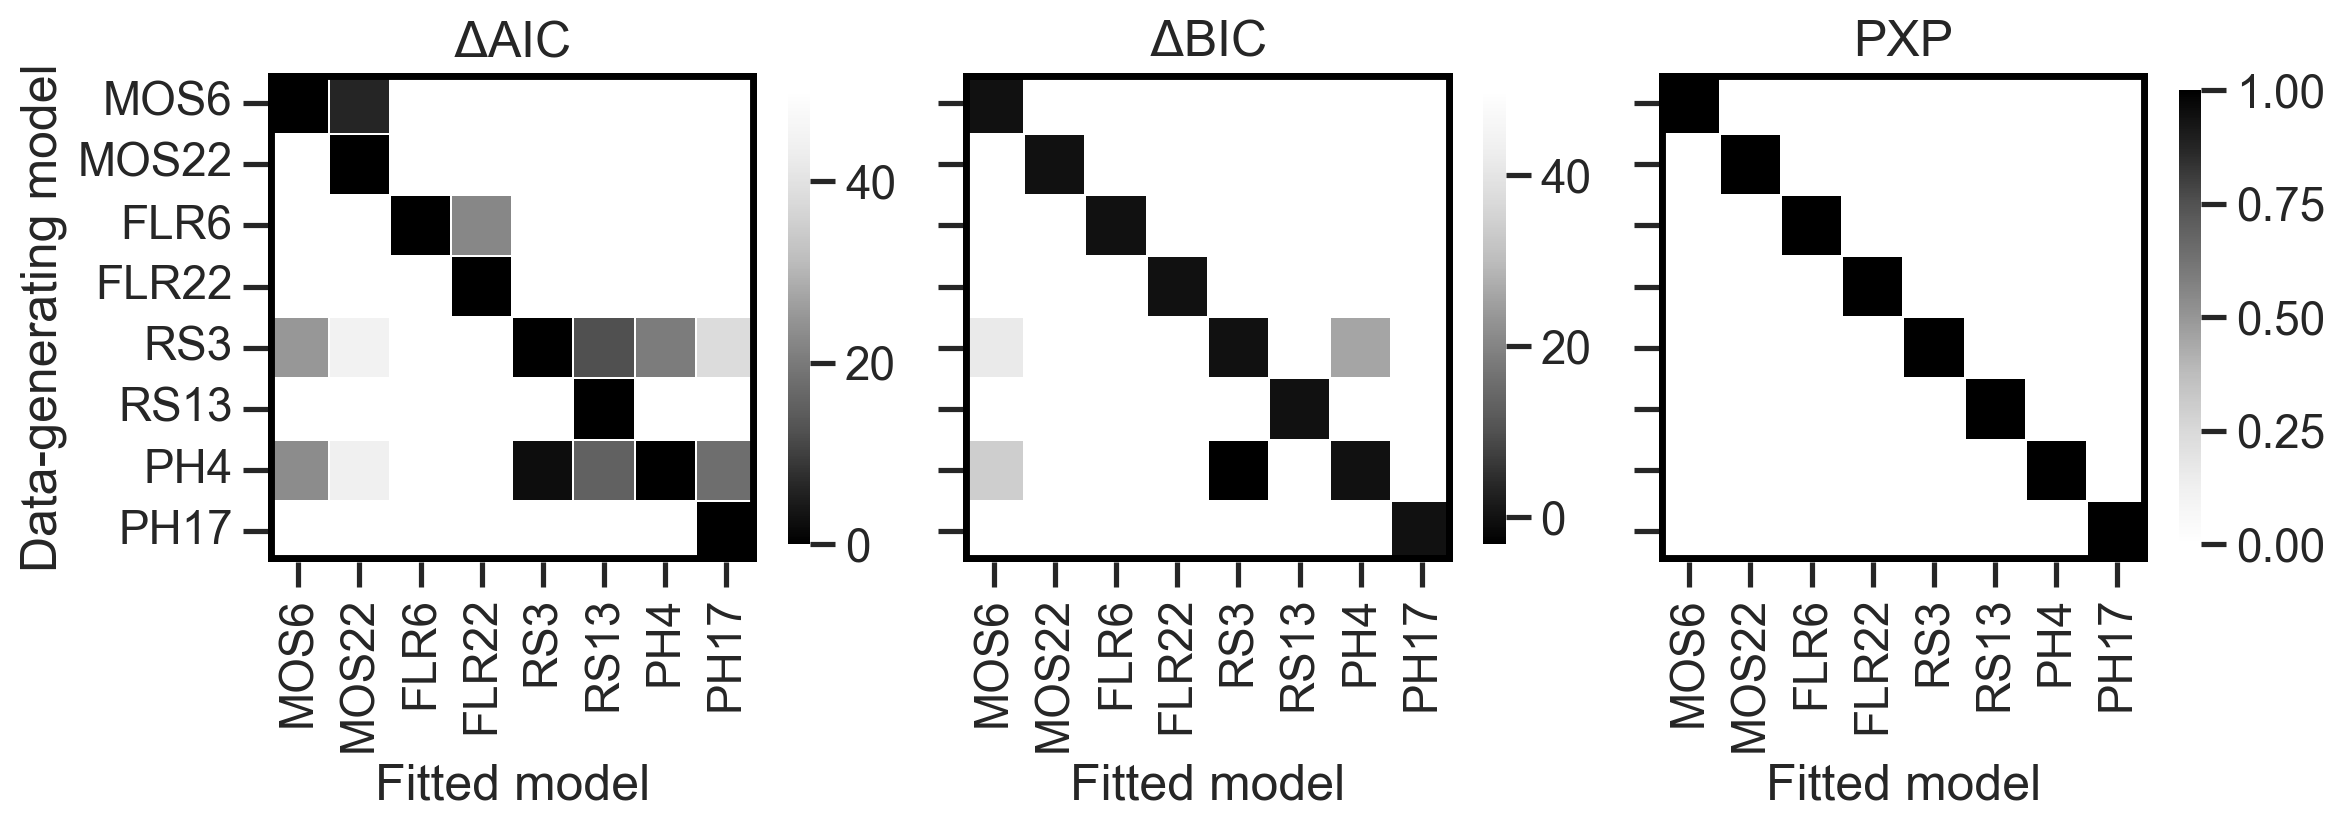

In [43]:
tars   = ['MOS6', 'MOS22', 'FLR6', 'FLR22', 'RS3', 'RS13', 'PH4', 'PH17']
models = ['MOS6', 'MOS22', 'FLR6', 'FLR22', 'RS3', 'RS13', 'PH4', 'PH17']
method = 'map'    
get_recovery_matrix(tars, models, method)
plt.savefig('../figures/Fig7B_model_recovery.pdf', dpi=300)